# Measure the density profile of a Dark Matter Halo

The Navarro–Frenk–White (NFW) profile is a spatial mass distribution of dark matter fitted to dark matter halos identified in N-body simulations by Julio Navarro, Carlos Frenk and Simon White (https://ui.adsabs.harvard.edu/abs/1996ApJ...462..563N/abstract). The NFW profile is one of the most commonly used model profiles for dark matter halos.

In the NFW profile, the density of dark matter as a function of radius is given by:

\begin{equation}
\rho (r)={\frac {\rho _{0}}{{\frac {r}{R_{s}}}\left(1~+~{\frac {r}{R_{s}}}\right)^{2}}}
\end{equation}

The integrated mass within some radius $R_{max}$ is

\begin{equation}
M=\int _{0}^{R_{\max }}4\pi r^{2}\rho (r)\,dr=4\pi \rho _{0}R_{s}^{3}\left[\ln \left({\frac {R_{s}+R_{\max }}{R_{s}}}\right)+{\frac {R_{s}}{R_{s}+R_{\max }}}-1\right]
\end{equation}

# 1 Simulate a Dark Matter Halo

How to sample particles according to a given density profile?

Inverse transform sampling

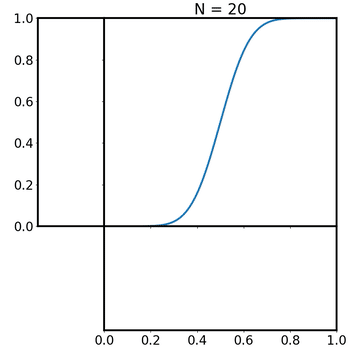

https://en.wikipedia.org/wiki/Inverse_transform_sampling

In [1]:
import numpy as np
import pylab as pl
from scipy import interpolate

#--------------------------------------------------------------------
def xy_rotate(x, y, xcen, ycen, phi):
    phirad = np.deg2rad(phi)
    xnew = (x-xcen)*np.cos(phirad)+(y-ycen)*np.sin(phirad)
    ynew = (y-ycen)*np.cos(phirad)-(x-xcen)*np.sin(phirad)
    return xnew+xcen,ynew+ycen

#--------------------------------------------------------------------
def rho_NFW(r, rho_0, R_s):
    # complete the function according to the equation above
    res = rho_0/((r/R_s)*(1 + r/R_s)**2)
    return res
#--------------------------------------------------------------------
def mass_rmax_NFW(R_max, rho_0, R_s):
    # complete the function according to the equation above
    res = 4*np.pi*rho_0*R_s**3*(np.log(1 + R_max/R_s) + 1/(1+R_max/R_s) - 1)
    return res
#--------------------------------------------------------------------
def invert_CDF_NFW(R_max, rho_0, R_s):
    rr = np.linspace(0.0, R_max, 1000)
    mm = mass_rmax_NFW(rr, rho_0, R_s)
    # build a function based on the arrays [mm, rr] with scipy.interpolate.interp1d
    res = interpolate.interp1d(mm, rr)
    return res
#--------------------------------------------------------------------
def sample_particles_R_NFW(num_Prtcls, R_max, rho_0, R_s):
    y_arr_01 = np.random.random(num_Prtcls)
    m_R_max = mass_rmax_NFW(R_max, rho_0, R_s)
    y_arr = m_R_max*y_arr_01
    func_tmp = invert_CDF_NFW(R_max, rho_0, R_s)
    # calculate R using the values above with for loop and list
    res = np.array([func_tmp(y_i) for y_i in y_arr])
    return res
#--------------------------------------------------------------------
def sample_particles_XYZ_NFW(num_prtcls, R_max, rho_0, R_s, xcen=0.0, ycen=0.0, zcen=0.0):
    ra = sample_particles_R_NFW(num_prtcls, R_max, rho_0, R_s)
    theta = np.arccos(np.random.random_sample(num_prtcls)*2.0-1.0)
    psi = 2.0*np.pi*np.random.random_sample(num_prtcls)
    rx = ra*np.sin(theta)*np.cos(psi)*0.7 + xcen
    ry = ra*np.sin(theta)*np.sin(psi)/0.7 + ycen
    rz = ra*np.cos(theta) + zcen
    rxr, ryr = xy_rotate(rx,ry,xcen,ycen,37)
    rzr = rz
    return rxr, ryr, rzr

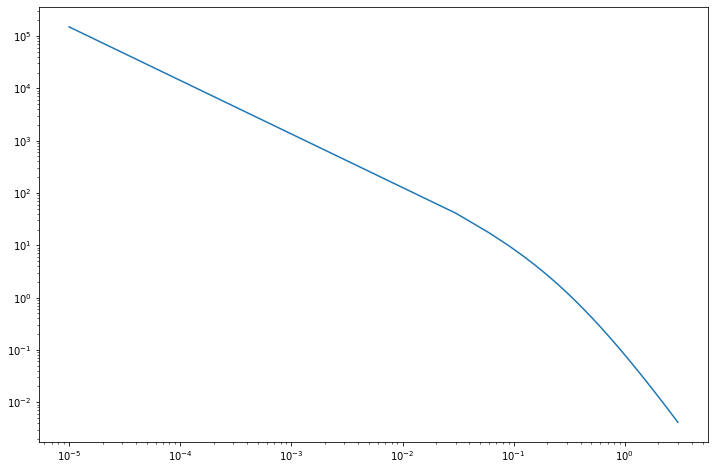

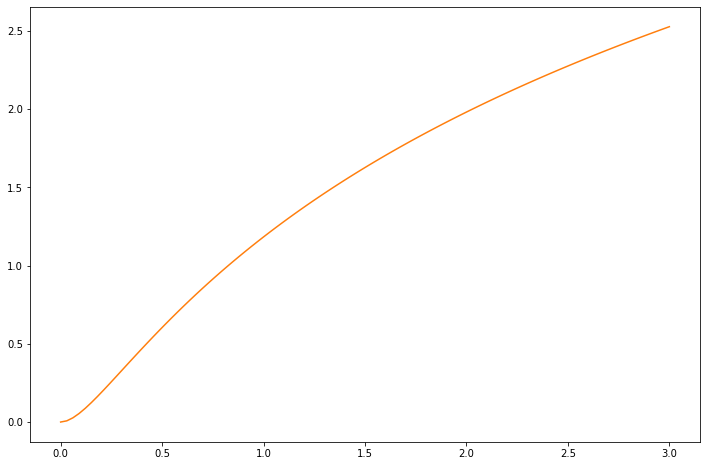

In [2]:
# visualize the functions you created

R_max_0 = 3.0
R_s_0 = 0.3
rho_0_0 = 5.0

nbins = 100
rbins = np.linspace(1e-5, R_max_0, nbins)

# complete the code below
pl.figure(figsize=(12, 8))
pl.loglog(rbins, rho_NFW(rbins, rho_0_0, R_s_0), 'C0-', label='NFW Density Profile')

pl.figure(figsize=(12, 8))
pl.plot(rbins, mass_rmax_NFW(rbins, rho_0_0, R_s_0), 'C1-', label='NFW Enclosed-mass Model')

(-5.0, 5.0)

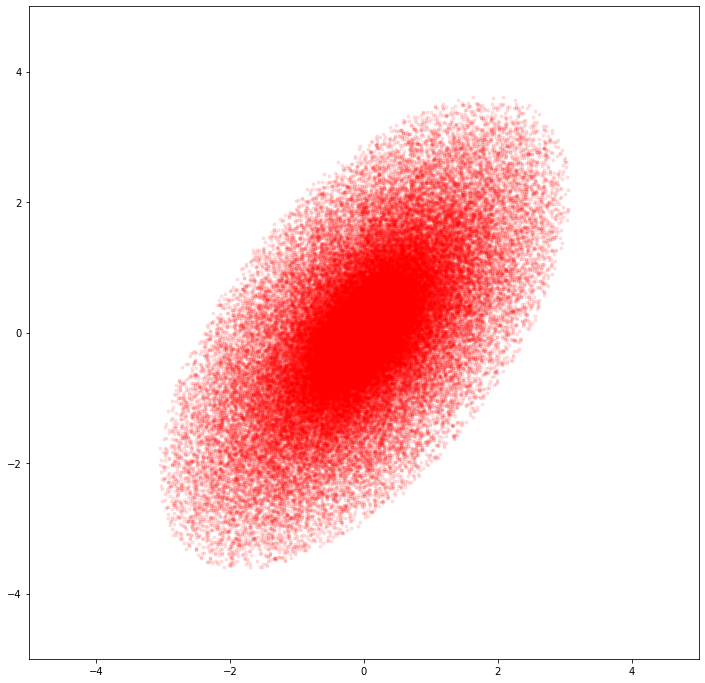

In [3]:
nPrtcls = 100000
mPrtcls = mass_rmax_NFW(R_max_0, rho_0_0, R_s_0)/nPrtcls

# complete the code below
xt, yt, zt = sample_particles_XYZ_NFW(nPrtcls, R_max_0, rho_0_0, R_s_0)
rt = np.sqrt(xt*xt + yt*yt + zt*zt) # calculate radii of particles

# visualize the simulated halo
pl.figure(figsize=(12, 12))
pl.plot(xt, yt, 'r.', alpha=0.1) # try different alpha values
pl.xlim(-5, 5)
pl.ylim(-5, 5)

# 2 Fit the data to the NFW profile
## 2.1 Fit to NFW density profile

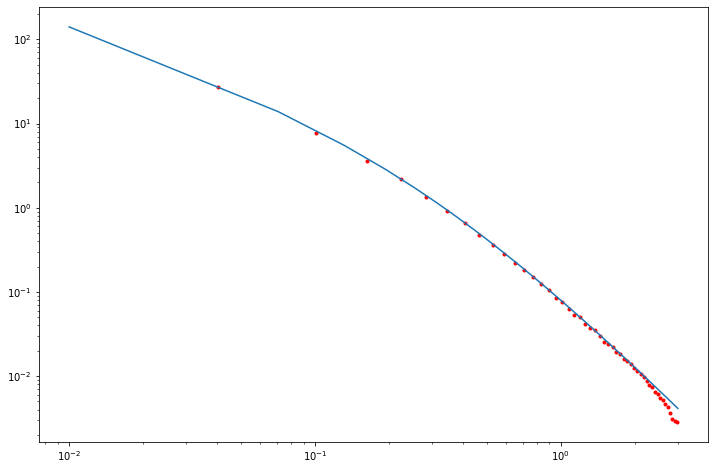

In [4]:
# In linear space

nbins = 50
rbins = np.linspace(1e-2, R_max_0, nbins)

rb = []
yb = []
eb = []
for i in range(nbins-1):
    idx1 = rt > rbins[i]
    idx2 = rt <= rbins[i+1]
    idx = idx1&idx2
    rb_tmp = (rbins[i+1] + rbins[i])*0.5
    dr_tmp = (rbins[i+1] - rbins[i])
    # how to calculate density profile within the bin above?
    yb_tmp = len(rt[idx])*mPrtcls/(4.0*np.pi*rb_tmp**2.0*dr_tmp)
    rb.append(rb_tmp)
    yb.append(yb_tmp)
    eb.append(np.sqrt(len(rt[idx]))) # what is this?
    
pl.figure(figsize=(12, 8))
pl.loglog(rb, yb, 'r.') 
pl.loglog(rbins, rho_NFW(rbins, rho_0_0, R_s_0), '-')

[3.97714131 0.34420276]


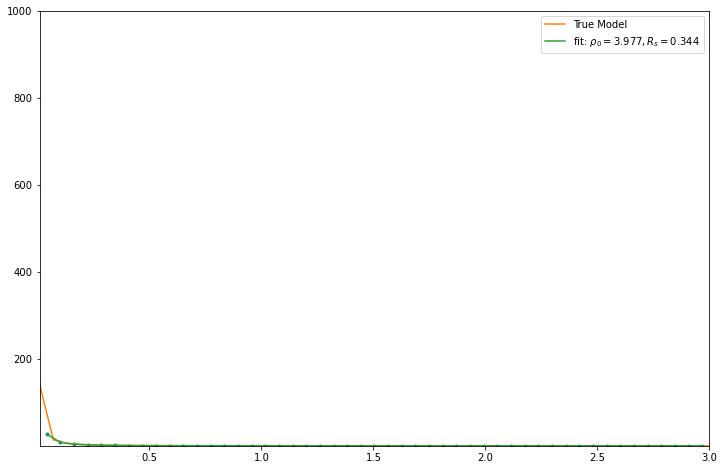

In [13]:
from scipy.optimize import curve_fit

# complete the code below
popt, pcov = curve_fit(rho_NFW, rb, yb)#, sigma=eb)

print(popt)

pl.figure(figsize=(12, 8))
pl.plot(rb, yb, 'C0.') 
pl.plot(rbins, rho_NFW(rbins, rho_0_0, R_s_0), 'C1-', label='True Model')
pl.plot(rb, rho_NFW(rb, *popt), 'C2-',
         label=r'fit: $\rho_0=%5.3f, R_s=%5.3f$' % tuple(popt))
pl.xlim(0.01, R_max_0)
pl.ylim(1e-3, 1e3)
pl.legend()

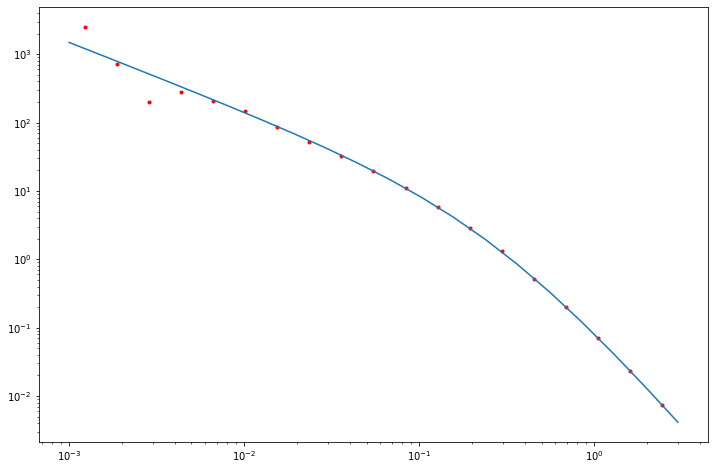

In [14]:
# In logarithm space

nbins = 20

# build logarithm bins
rbins = np.logspace(-3, np.log10(R_max_0), nbins)

rb = []
yb = []
eb = []
for i in range(nbins-1):
    idx1 = rt > rbins[i]
    idx2 = rt <= rbins[i+1]
    idx = idx1&idx2
    # how to calcuate centers of bins in logarithm space?
    rb_tmp = 10**((np.log10(rbins[i+1]) + np.log10(rbins[i]))*0.5)
    dr_tmp = (rbins[i+1] - rbins[i])
    # how to calculate yb?
    yb_tmp = len(rt[idx])*mPrtcls/(4.0*np.pi*rb_tmp**2.0*dr_tmp)
    rb.append(rb_tmp)
    yb.append(yb_tmp)
    eb.append(np.sqrt(len(rt[idx])))

pl.figure(figsize=(12, 8))
pl.loglog(rb, yb, 'r.') 
pl.loglog(rbins, rho_NFW(rbins, rho_0_0, R_s_0), '-')

/var/folders/7z/hdr_2hpx1td2cw2cxslg7d1w0000gs/T/ipykernel_41050/1671342608.py:7: RuntimeWarning: invalid value encountered in log10
  return np.log10(res)


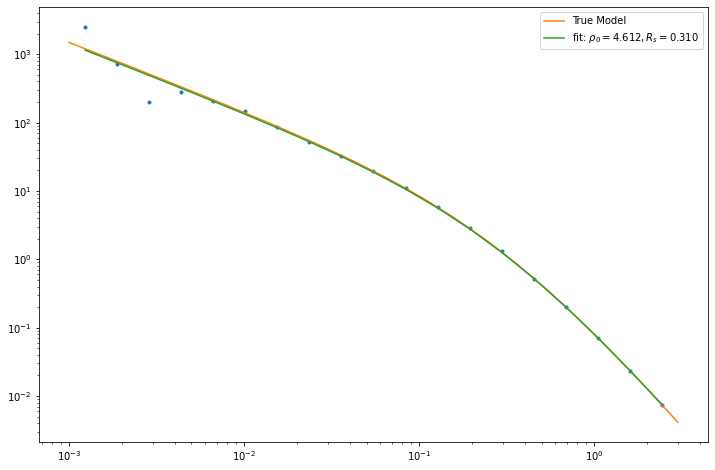

In [15]:
from scipy.optimize import curve_fit

def log_rho_NFW(log_r, rho_0, R_s):
    r = 10**log_r
    # define rho_NFW in logarithm space
    res = rho_0/((r/R_s)*(1 + r/R_s)**2)
    return np.log10(res)

log_rb = np.log10(rb)
log_yb = np.log10(yb)
idx_inf = np.isinf(log_yb) # remove infs, think of how to remove NaNs?
popt, pcov = curve_fit(log_rho_NFW, log_rb[~idx_inf], log_yb[~idx_inf])#, sigma=eb)

pl.figure(figsize=(12, 8))
pl.loglog(rb, yb, 'C0.') 
pl.loglog(rbins, rho_NFW(rbins, rho_0_0, R_s_0), 'C1-', label='True Model')
pl.loglog(rb, rho_NFW(rb, *popt), 'C2-',
         label=r'fit: $\rho_0=%5.3f, R_s=%5.3f$' % tuple(popt))
pl.legend()

## 2.2 Fit to NFW mass model

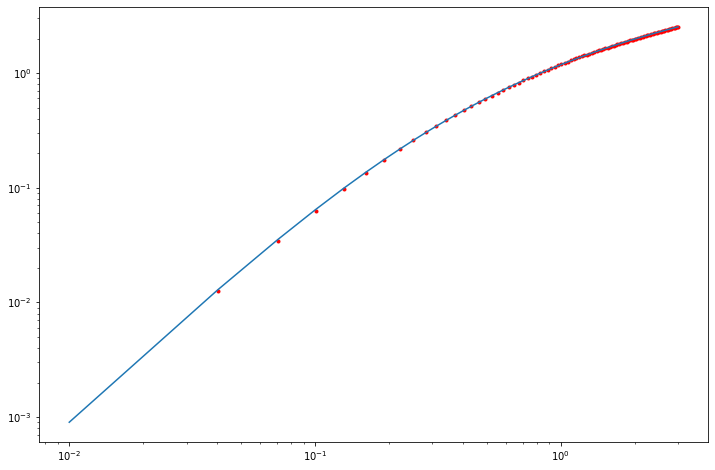

In [16]:
nbins = 100
rbins = np.linspace(1e-2, R_max_0, nbins)

rb = []
yb = []
eb = []
for i in range(nbins-1):
    idx = rt<rbins[i+1]
    rb_tmp = rbins[i+1]
    # how to calculate yb_tmp here?
    yb_tmp = len(rt[idx])*mPrtcls
    rb.append(rb_tmp)
    yb.append(yb_tmp)
    eb.append(np.sqrt(len(rt[idx])))

pl.figure(figsize=(12, 8))
pl.loglog(rb, yb, 'r.') 
pl.loglog(rbins, mass_rmax_NFW(rbins, rho_0_0, R_s_0), '-')

[5.16541718 0.29594181]
[[ 3.92143001e-04 -9.54004028e-06]
 [-9.54004028e-06  2.32551088e-07]]


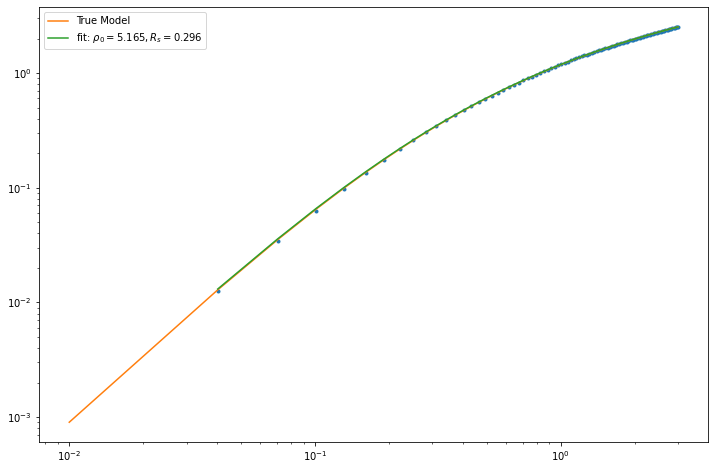

In [17]:
from scipy.optimize import curve_fit

# complete the code below
popt, pcov = curve_fit(mass_rmax_NFW, rb, yb) #, sigma=eb)

print(popt)
print(pcov)

pl.figure(figsize=(12, 8))
pl.loglog(rb, yb, 'C0.') 
pl.loglog(rbins, mass_rmax_NFW(rbins, rho_0_0, R_s_0), 'C1-', label='True Model')
pl.loglog(rb, mass_rmax_NFW(rb, *popt), 'C2-',
         label=r'fit: $\rho_0=%5.3f, R_s=%5.3f$' % tuple(popt))
pl.legend()

- Why the latter method gets better estimates? 

- If you do not know the true input, how to describe the goodness of fitting?

- The next class: `parameter estimation` with Monte Carlo Markov Chain
    - https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo
    - http://www.columbia.edu/~mh2078/MachineLearningORFE/MCMC_Bayes.pdf
    
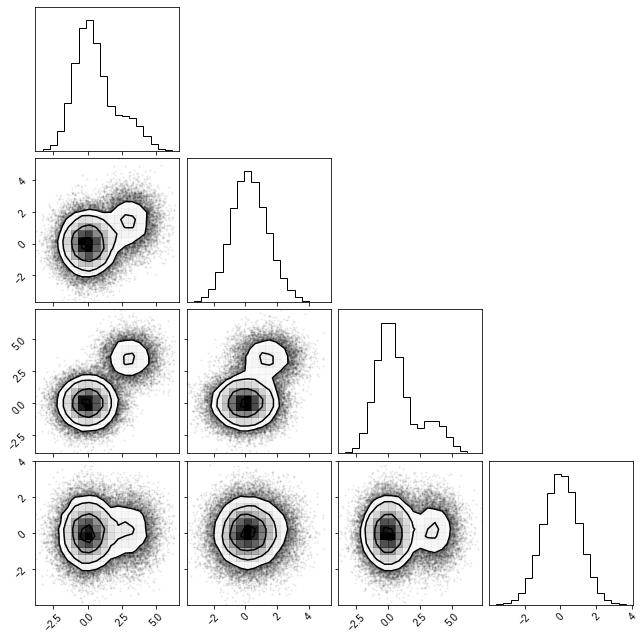